# Setup
in enrich summary, addded Rev_per_dist

In [2]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy.stats import sem
import os
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl

plt.style.use('ggplot')
%matplotlib inline


# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

taxi_file_names = {
    "2018_01": 'datasets/yellow_tripdata_2018-01.csv'
}
taxi_zone_lkup_csv='datasets/taxi_zone_lookup.csv'

In [3]:
def retrieve_summary(zone_lkup_file, taxi_file_names, gb_field):
    taxi_zone_lkup_df = pd.read_csv(taxi_zone_lkup_csv)
    # chunk_list = []  # append each chunk df here     
    gb_field_list = ["trip_count","total_revenue","total_time_min","total_miles"]

    gb_final_file_df = pd.DataFrame()

    for file_key in taxi_file_names: 
        clean_file_df = clean_file(taxi_file_names[file_key], taxi_zone_lkup_df, file_key, gb_field)
        gb_clean_file_df = groupby(clean_file_df, gb_field, gb_field_list)
        gb_final_file_df = gb_final_file_df.append(gb_clean_file_df)
        print(file_key)

    gb_final_file_df = groupby(gb_final_file_df, gb_field, gb_field_list)
    gb_final_file_df = enrich_summary(gb_final_file_df)
    
    return gb_final_file_df

#gives averages (after sum levels have been added)
def enrich_summary(df):
    new_df = df
    new_df['avg_min_ptrip'] = new_df['total_time_min']/new_df['trip_count']
    new_df['avg_dist_ptrip'] = new_df['total_miles']/new_df['trip_count']
    new_df['avg_rev_ptrip'] = new_df['total_revenue']/new_df['trip_count']
    
    new_df['avg_dist_pmin'] = new_df['total_miles']/new_df['total_time_min']
    new_df['avg_rev_pmin'] = new_df['total_revenue']/new_df['total_time_min']
    
    #Teresa's addition
    new_df['rev_per_dist'] = new_df['total_revenue']/new_df['total_miles']

    return new_df


def clean_file(csv, taxi_zone_lkup_df, file_key, gb_field):
    
    chunks_df = pd.read_csv(csv, chunksize=1000000)    
    gb_field_list = ["PULocationID","total_amount","trip_time_min","trip_distance"]
    
    new_gb_df = pd.DataFrame()    
    
    for chunk_df in chunks_df:  
        clean_chunk_df = clean_chunk(chunk_df, taxi_zone_lkup_df, file_key)
        gb_clean_chunk_df = groupby(clean_chunk_df, gb_field, gb_field_list)
        # Once the data filtering is done, append the chunk to list
        new_gb_df = new_gb_df.append(gb_clean_chunk_df)
    return new_gb_df


def clean_chunk(df, zone_lkup_df, file_key):
    new_df = remove_unwanted_columns(df)
    new_df = remove_unwanted_rows(new_df, file_key)
    new_df = add_new_columns(new_df, zone_lkup_df)
    return new_df

def remove_unwanted_columns(df):
    new_df = df.drop(['VendorID', 'store_and_fwd_flag','fare_amount',
                    'extra', 'mta_tax','tolls_amount',
                    'improvement_surcharge'], axis=1) 
    return new_df

def remove_unwanted_rows(df, file_key):
    new_df = df 
    new_df['year'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).year
    new_df['month'] = pd.DatetimeIndex(new_df['tpep_pickup_datetime']).month
    
    file_month = file_key.split("_")[1]
    file_year = file_key.split("_")[0] 

    new_df = new_df.loc[(new_df["month"] == float(file_month)) & 
                        (new_df["year"] == float(file_year)), :]

#     new_df = df.drop(['year', 'month'], axis=1)    

    return new_df

def add_new_columns(df, zone_lkup_df):
    #set convert lkup_df to dictionary to leverage 'map' method
    taxi_zone_dic = pd.Series(zone_lkup_df.Zone.values, index=zone_lkup_df.LocationID).to_dict()

    new_df = df
    #create 2 columns for zone_name
    new_df['PU_zone_name'] = new_df.PULocationID.map(taxi_zone_dic)
    new_df['DO_zone_name'] = new_df.DOLocationID.map(taxi_zone_dic)

    #create 2 columns for time
    new_df['trip_time'] = pd.to_datetime(new_df["tpep_dropoff_datetime"]) - pd.to_datetime(new_df["tpep_pickup_datetime"])
    new_df['trip_time_min'] = new_df['trip_time'].dt.total_seconds()/60
    
    new_df['day_of_week'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.day_name()
    new_df['hour_of_day'] = pd.to_datetime(new_df["tpep_pickup_datetime"]).dt.hour
    
    
    return new_df

# used in chunking phase and final summary phase
def groupby(df, gb_field_name, fields):
    groupby = df.groupby([gb_field_name])
    gb_trip_rev_total = groupby[fields[1]].sum()
    gb_trip_time_total = groupby[fields[2]].sum()
    gb_trip_miles_total = groupby[fields[3]].sum()
    
    if fields[0] == 'trip_count':
        gb_trip_count = groupby[fields[0]].sum()
    else:
        gb_trip_count = groupby[fields[0]].count()
        
    new_df = pd.DataFrame({"trip_count": gb_trip_count,
                          "total_revenue": gb_trip_rev_total,
                          "total_time_min": gb_trip_time_total,
                          "total_miles": gb_trip_miles_total})
    
    return new_df

In [4]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [5]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])
    
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        cbar1=plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1),label=('Total Revenue'))
        #TX: add colorbar label
        #cbar1.ax.set_title('Total Revenue')
        
          
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center',fontsize=3)
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

# Create DFs grouped by PU zone name and zone id

In [6]:
df_PU = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "PULocationID")
df_PU = df_PU.reset_index()

2018_01


In [7]:
pu_zone_df = retrieve_summary(taxi_zone_lkup_csv, taxi_file_names, "PU_zone_name")

2018_01


# Make a heatmap based on taxi_zone shapefile
Referenced another project: https://chih-ling-hsu.github.io/2018/05/14/NYC#location-data

In [10]:
PUrev = dict(zip(df_PU['PULocationID'].tolist(), df_PU['total_revenue'].tolist()))

In [4]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,zone,longitude,latitude
0,1,1,0.000782,0.116357,EWR,Newark Airport,9.366817e+05,190522.130278
1,2,2,0.004866,0.433470,Queens,Jamaica Bay,1.033536e+06,161853.982300
2,3,3,0.000314,0.084341,Bronx,Allerton/Pelham Gardens,1.027136e+06,254730.010849
3,4,4,0.000112,0.043567,Manhattan,Alphabet City,9.904240e+05,203100.040432
4,5,5,0.000498,0.092146,Staten Island,Arden Heights,9.321332e+05,139954.541936


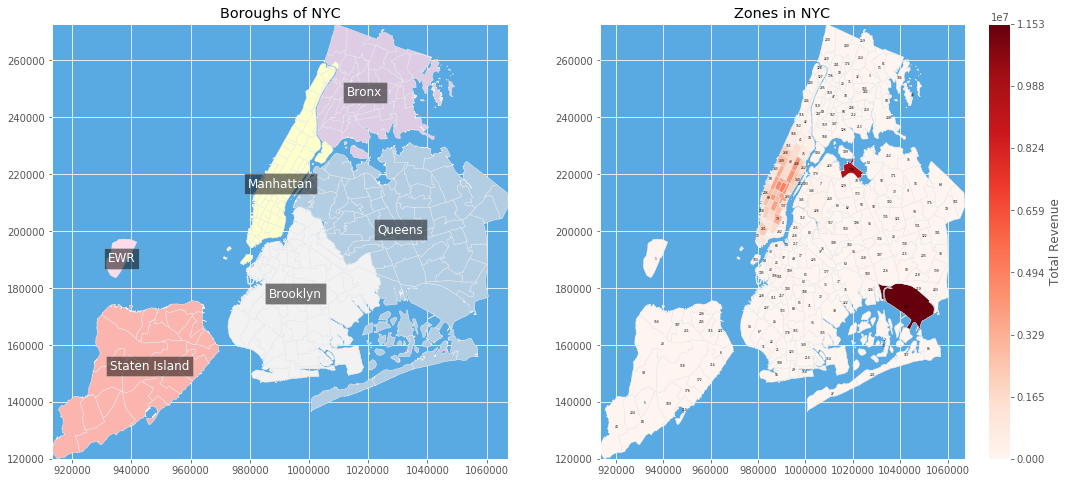

In [13]:
#Uncomment this to run
#DO NOT RUN MORE THAN ONCE, WILL TAKE 5EVER

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
#ax = plt.subplot(1, 2, 2)
#ax.set_title("Zones in NYC")
#draw_zone_map(ax, sf, heat=PUrev, text=[])

#ax=plt.subplot(1,2,1)
#ax.set_title("Boroughs of NYC")
#draw_region_map(ax,sf)

#fig.savefig('revenue_map_out',format='png')

In [23]:
#What are the top zones?
# grab most important columns for plotting and sort by revenue per minute
preview_df=pu_zone_df[['total_revenue','trip_count','total_time_min','total_miles','avg_rev_pmin',]]
pu_top5_totalrev=preview_df.sort_values(by='total_revenue',ascending=False).reset_index().head(5)
pu_top5_totalrev

,PU_zone_name,total_revenue,trip_count,total_time_min,total_miles,avg_rev_pmin
0,JFK Airport,1.152931e+07,203377,8.610943e+06,3220795.69,1.338914
1,LaGuardia Airport,9.821090e+06,233164,7.667790e+06,2279603.83,1.280824
2,Midtown Center,5.022166e+06,354922,5.490032e+06,794953.02,0.914779
3,Times Sq/Theatre District,4.748257e+06,309169,5.200581e+06,808610.35,0.913024
4,Midtown East,4.340428e+06,308292,4.518070e+06,697543.22,0.960682


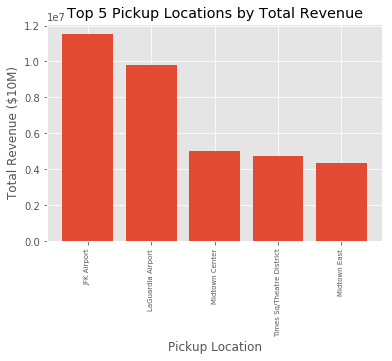

<Figure size 432x288 with 0 Axes>

In [34]:
x = pu_top5_totalrev.PU_zone_name
y = pu_top5_totalrev.total_revenue
fig=plt.bar(x,y)
plt.xlabel('Pickup Location')
plt.ylabel('Total Revenue ($10M)' )
plt.title('Top 5 Pickup Locations by Total Revenue')
plt.tick_params(axis='x', which='major', labelsize=7)
plt.xticks(rotation=90)

plt.show()
plt.savefig('top5hist_totalrev.png')

# Create histogram of PU zones with top rev/min

In [15]:
# grab most important columns for plotting and sort by revenue per minute
preview_df=pu_zone_df[['total_revenue','trip_count','total_time_min','total_miles','avg_rev_pmin',]]
preview_df.sort_values(by='avg_rev_pmin',ascending=False).head(7)

,total_revenue,trip_count,total_time_min,total_miles,avg_rev_pmin
PU_zone_name,,,,,
Charleston/Tottenville,89.80,1,0.066667,0.00,1347.000000
Arden Heights,221.76,2,0.583333,0.00,380.160000
Port Richmond,60.17,2,2.533333,19.40,23.751316
Great Kills,478.10,7,32.283333,6.80,14.809499
Newark Airport,50361.87,571,3490.300000,1267.72,14.429095
Oakwood,159.16,2,13.183333,3.90,12.072819
City Island,101.45,3,12.933333,5.00,7.844072


In [11]:
pu_top5_revpmin

,PU_zone_name,trip_count,total_time_min,total_miles,avg_rev_pmin,rev_per_dist
0,Newark Airport,571,3490.300000,1267.72,14.429095,39.726335
1,Randalls Island,258,5242.266667,1748.84,2.971854,8.908334
2,Richmond Hill,310,4344.150000,1416.16,2.172172,6.663258
3,Corona,322,5767.383333,1855.81,2.148779,6.677855
4,South Ozone Park,693,18309.083333,5927.92,2.020351,6.240093


In [9]:
#To mitigate skewed "average revenue per minute" datapoints, only pull in pu_zones that have trip counts above a threshold
#use summary statistics to see what would be a reasonable threshold
pu_zone_df['trip_count'].describe()

count       257.000000
mean      34068.929961
std       76999.482334
min           1.000000
25%          68.000000
50%         310.000000
75%        8827.000000
max      360976.000000
Name: trip_count, dtype: float64

First two rows are bad data, since the total time is a fraction of a minute, and the avg revenue is really high 

In [40]:
#filter by trip_count > 100 per zone -- chose 100 so that most of the data can be captured even with threshold
over_100_pickups = pu_zone_df[pu_zone_df['trip_count']>100]
over_100_pickups= over_100_pickups[['avg_rev_pmin','trip_count','total_time_min','total_miles']]

#get the top5 dropoff locations based on revenue per minute, revenue per distance
pu_top5_revpmin = over_100_pickups.sort_values(by=['avg_rev_pmin'],ascending=False).reset_index().head(5)
pu_top5_revpmin

,PU_zone_name,avg_rev_pmin,trip_count,total_time_min,total_miles
0,Newark Airport,14.429095,571,3490.300000,1267.72
1,Randalls Island,2.971854,258,5242.266667,1748.84
2,Richmond Hill,2.172172,310,4344.150000,1416.16
3,Corona,2.148779,322,5767.383333,1855.81
4,South Ozone Park,2.020351,693,18309.083333,5927.92


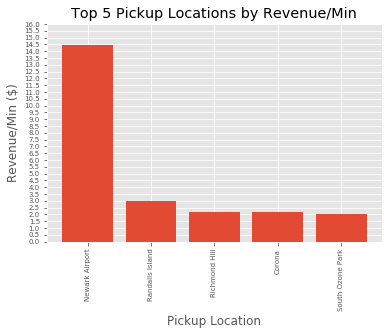

<Figure size 432x288 with 0 Axes>

In [37]:
x = pu_top5_revpmin.PU_zone_name
y = pu_top5_revpmin.avg_rev_pmin
yticks=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16]

fig=plt.bar(x,y)
plt.xlabel('Pickup Location')
plt.ylabel('Revenue/Min ($)' )
plt.title('Top 5 Pickup Locations by Revenue/Min')
plt.tick_params(axis='x', which='major', labelsize=7)
plt.yticks(yticks,fontsize=7)
plt.xticks(rotation=90)

#plt.tight_layout()
plt.show()
plt.savefig('top5hist_revpmin.png')